In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

#Load Data dan EDA visualisasi
from google.colab import drive
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#preparation (pipeline)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization,GlobalAveragePooling2D, Activation
from tensorflow.keras import Input, Model
from tensorflow.keras import initializers

#model evaluation
from sklearn.metrics import classification_report

#Inference
from IPython.display import Image
from google.colab import files
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims

# Import Data

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
% cd /content/gdrive/MyDrive/data_tomat

/content/gdrive/MyDrive/data_tomat


In [ ]:
! ls

train  valid


# EDA

In [ ]:
#Untuk melihat jumlah Images dari tiap kelas

for dirpath, dirnames, filenames in os.walk('.'):
  print(f"Ada {len(dirnames)} folder dan {len(filenames)} gambar di dalam {dirpath}")

Ada 2 folder dan 0 gambar di dalam .
Ada 11 folder dan 0 gambar di dalam ./valid
Ada 0 folder dan 425 gambar di dalam ./valid/Tomato___Bacterial_spot
Ada 0 folder dan 457 gambar di dalam ./valid/Tomato___Target_Spot
Ada 0 folder dan 481 gambar di dalam ./valid/Tomato___healthy
Ada 0 folder dan 463 gambar di dalam ./valid/Tomato___Late_blight
Ada 0 folder dan 490 gambar di dalam ./valid/Tomato___Tomato_Yellow_Leaf_Curl_Virus
Ada 0 folder dan 448 gambar di dalam ./valid/Tomato___Tomato_mosaic_virus
Ada 0 folder dan 480 gambar di dalam ./valid/Tomato___Early_blight
Ada 0 folder dan 436 gambar di dalam ./valid/Tomato___Septoria_leaf_spot
Ada 0 folder dan 435 gambar di dalam ./valid/Tomato___Spider_mites Two-spotted_spider_mite
Ada 0 folder dan 470 gambar di dalam ./valid/Tomato___Leaf_Mold
Ada 0 folder dan 126 gambar di dalam ./valid/unknown
Ada 11 folder dan 0 gambar di dalam ./train
Ada 0 folder dan 1056 gambar di dalam ./train/Tomato___Tomato_Yellow_Leaf_Curl_Virus
Ada 0 folder dan 1001

In [ ]:
#membuat kelas (label) berdasarkan nama folder
data_dir = pathlib.Path('./train/')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy' 'unknown']


# Preprocessing

In [ ]:
img_size = 224
batch_size = 20
input_shape = (224,224,3)
grid_shape = (1, 224, 224, 3)


In [ ]:
# set direktori
train_dir = './train/'
valid_dir = './valid/'

In [ ]:
traingen = ImageDataGenerator(rescale=1/255.0)
valgen = ImageDataGenerator(rescale=1/255.0)
# # train_datagen_augmented = ImageDataGenerator(rescale=1./255,
# #                                              rotation_range=0.2,
# #                                              zoom_range=0.2,
# #                                              width_shift_range=0.2,
# #                                              height_shift_range=0.2,
# #                                              horizontal_flip=True)


In [ ]:
#set data generator
train_data = traingen.flow_from_directory(train_dir,
                                          batch_size=batch_size,
                                          target_size=(img_size, img_size),
                                          class_mode='categorical',
                                          seed=8)


valid_data = valgen.flow_from_directory(valid_dir,
                                        batch_size=batch_size,
                                        target_size=(img_size, img_size),
                                        class_mode='categorical',
                                        seed=8)

# # train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
# #                                                batch_size=32,
# #                                                target_size=(150, 150),
# #                                                class_mode='categorical',
# #                                                seed=8)

Found 10649 images belonging to 11 classes.
Found 4684 images belonging to 11 classes.


In [ ]:
train_data.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9,
 'unknown': 10}

In [ ]:
class_name = ['Bacterial_spot',
              'Early_blight',
              'Late_blight',
              'Leaf_Mold',
              'Septoria_leaf_spot',
              'Spider_mites Two-spotted_spider_mite',
              'Target_Spot',
              'Tomato_Yellow_Leaf_Curl_Virus',
              'Tomato_mosaic_virus',
              'healthy',
              'unknown']

# EDA

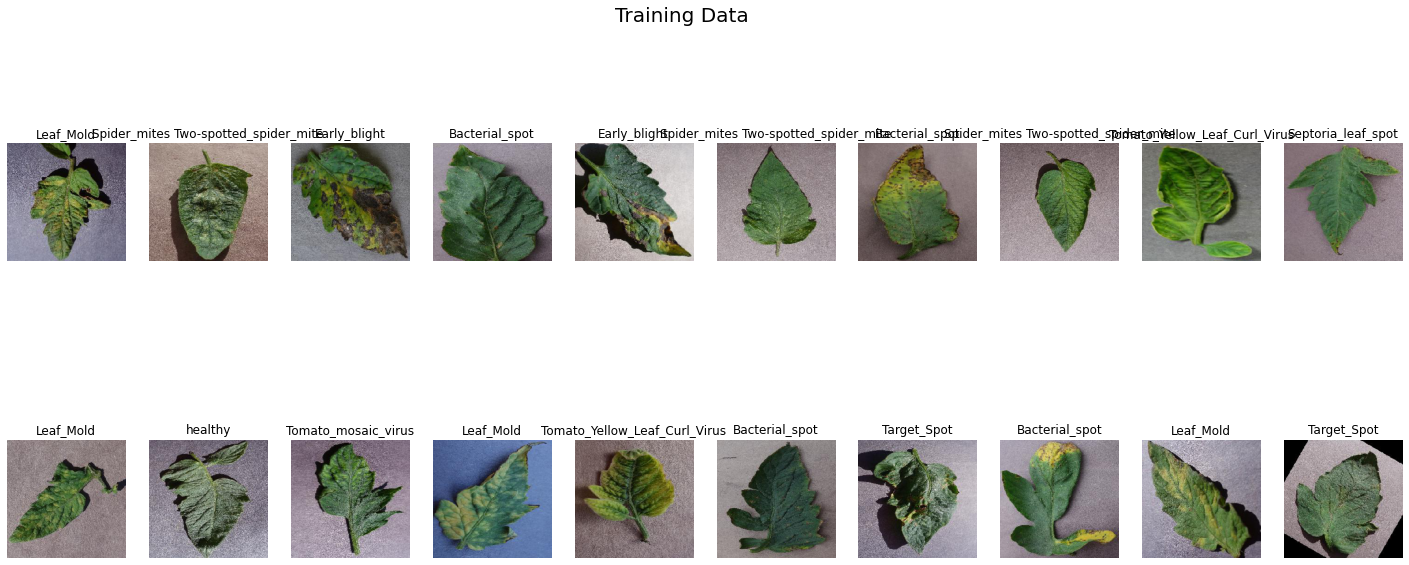

In [ ]:
plt.figure(figsize=(25, 10))
plt.suptitle('Training Data', fontsize=20)
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(class_name[np.argmax(train_data[i][1][0])])
    plt.axis('off')
plt.show()

# Modelling

## transfer learning

In [ ]:
mbnet = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                          weights="imagenet",
                                          include_top=False
)
mbnet.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#define the layers
inputs = keras.Input(shape=input_shape)

#get the layers
x = mbnet(inputs, training = False)

#stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(11, activation='softmax')(x)

#combine the model
mbnet_model = Model(inputs=inputs, outputs=x)

#summary
mbnet_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                40992     
                                                                 
 dense_9 (Dense)             (None, 11)                363 

In [ ]:
# compile model
mbnet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# train model
history_mbnet = mbnet_model.fit(train_data,
                                epochs=10,
                                validation_data=valid_data)

Epoch 1/10
533/533 [==============================] - 78s 139ms/step - loss: 0.9073 - accuracy: 0.6956 - val_loss: 0.5658 - val_accuracy: 0.8108
Epoch 2/10
533/533 [==============================] - 72s 136ms/step - loss: 0.4782 - accuracy: 0.8348 - val_loss: 0.4514 - val_accuracy: 0.8444
Epoch 3/10
533/533 [==============================] - 73s 136ms/step - loss: 0.3912 - accuracy: 0.8694 - val_loss: 0.3814 - val_accuracy: 0.8672
Epoch 4/10
533/533 [==============================] - 72s 135ms/step - loss: 0.3508 - accuracy: 0.8801 - val_loss: 0.4181 - val_accuracy: 0.8559
Epoch 5/10
533/533 [==============================] - 71s 134ms/step - loss: 0.3256 - accuracy: 0.8862 - val_loss: 0.3835 - val_accuracy: 0.8676
Epoch 6/10
533/533 [==============================] - 71s 134ms/step - loss: 0.3012 - accuracy: 0.8936 - val_loss: 0.3583 - val_accuracy: 0.8779
Epoch 7/10
533/533 [==============================] - 71s 134ms/step - loss: 0.2753 - accuracy: 0.8991 - val_loss: 0.3211 - val_ac

In [ ]:
mbnet_model.save('mbnet_model.h5')

In [ ]:
metrics_mbnet = pd.DataFrame(history_mbnet.history)

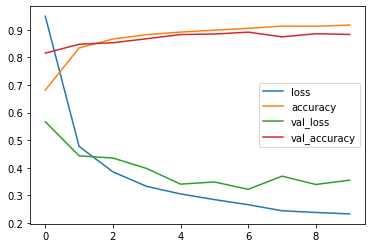

In [ ]:
metrics_mbnet.plot();

In [ ]:
loss, accuracy = mbnet_model.evaluate(valid_data)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

230/230 [==============================] - 21s 93ms/step - loss: 0.3552 - accuracy: 0.8831
Test accuracy : 0.8830970525741577
Test loss : 0.3551630675792694


In [ ]:
val_data = valid_data.next()
res = mbnet_model.predict(val_data[0])
print(classification_report(np.argmax(val_data[1], axis=1), np.argmax(res, axis=1), target_names=class_name))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.00      0.00      0.00         0
                        Early_blight       1.00      1.00      1.00         3
                         Late_blight       1.00      1.00      1.00         1
                           Leaf_Mold       1.00      1.00      1.00         1
                  Septoria_leaf_spot       1.00      0.50      0.67         2
Spider_mites Two-spotted_spider_mite       1.00      1.00      1.00         1
                         Target_Spot       0.67      1.00      0.80         2
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.33      0.50         3
                 Tomato_mosaic_virus       0.80      1.00      0.89         4
                             healthy       1.00      1.00      1.00         3

                            accuracy                           0.85        20
                           macro avg       0.85      0.78     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Base Model

In [ ]:
base_model = Sequential()
# Convolutional Layer 1
base_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
base_model.add(keras.layers.BatchNormalization())
base_model.add(MaxPool2D((2, 2)))
base_model.add(Dropout(0.2))

# # Convolutional Layer 2
# base_model.add(Conv2D(64, (3, 3), activation='relu'))
# base_model.add(keras.layers.BatchNormalization())
# base_model.add(MaxPool2D((2, 2)))
# base_model.add(Dropout(0.2))

# Convolutional Layer 3
base_model.add(Conv2D(128, (3, 3), activation='relu'))
base_model.add(keras.layers.BatchNormalization())
base_model.add(MaxPool2D((2, 2)))
base_model.add(Dropout(0.2))

base_model.add(Flatten())

# Fully Connected Layer 1
# base_model.add(Dense(32, activation='relu'))

# Fully Connected Layer 2
base_model.add(Dense(11, activation='softmax'))

In [ ]:
base_model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

In [ ]:
history_base_model = base_model.fit(train_data,
                                    epochs=10,
                                    validation_data=valid_data)

Epoch 1/10
513/513 [==============================] - 105s 202ms/step - loss: 41.5635 - accuracy: 0.6069 - val_loss: 139.7184 - val_accuracy: 0.2713
Epoch 2/10
513/513 [==============================] - 102s 198ms/step - loss: 18.2119 - accuracy: 0.7842 - val_loss: 58.1216 - val_accuracy: 0.5601
Epoch 3/10
513/513 [==============================] - 102s 198ms/step - loss: 9.3919 - accuracy: 0.8594 - val_loss: 15.9605 - val_accuracy: 0.8020
Epoch 4/10
513/513 [==============================] - 102s 198ms/step - loss: 5.9396 - accuracy: 0.9042 - val_loss: 22.2903 - val_accuracy: 0.7588
Epoch 5/10
513/513 [==============================] - 101s 197ms/step - loss: 4.3638 - accuracy: 0.9245 - val_loss: 69.3947 - val_accuracy: 0.5734
Epoch 6/10
513/513 [==============================] - 101s 197ms/step - loss: 3.6641 - accuracy: 0.9321 - val_loss: 27.0596 - val_accuracy: 0.7252
Epoch 7/10
513/513 [==============================] - 101s 197ms/step - loss: 2.4648 - accuracy: 0.9519 - val_loss:

In [ ]:
metrics_base_model = pd.DataFrame(history_base_model.history)

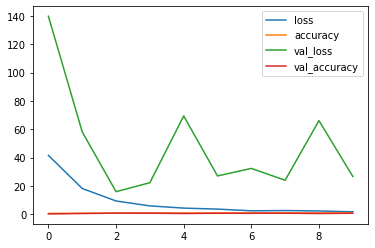

In [ ]:
metrics_base_model.plot();

In [ ]:
loss, accuracy = base_model.evaluate(valid_data)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

230/230 [==============================] - 22s 97ms/step - loss: 26.7255 - accuracy: 0.7446
Test accuracy : 0.7446019649505615
Test loss : 26.725549697875977


In [ ]:
val_data = valid_data.next()
res = base_model.predict(val_data[0])
print(classification_report(np.argmax(val_data[1], axis=1), np.argmax(res, axis=1), target_names=class_name))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.50      1.00      0.67         2
                        Early_blight       0.50      0.50      0.50         2
                         Late_blight       1.00      1.00      1.00         2
                           Leaf_Mold       0.50      1.00      0.67         1
                  Septoria_leaf_spot       0.00      0.00      0.00         2
Spider_mites Two-spotted_spider_mite       1.00      0.40      0.57         5
                         Target_Spot       0.00      0.00      0.00         1
       Tomato_Yellow_Leaf_Curl_Virus       0.00      0.00      0.00         0
                 Tomato_mosaic_virus       1.00      1.00      1.00         1
                             healthy       1.00      1.00      1.00         4

                            accuracy                           0.65        20
                           macro avg       0.55      0.59     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

# Resnet

In [ ]:
resnet = tf.keras.applications.ResNet50(input_shape=input_shape,
                                        weights='imagenet',
                                        include_top=False)
resnet.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#define the layers
inputs = keras.Input(shape=input_shape)

#get the layers
x = resnet(inputs, training = False)

#stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(11, activation='softmax')(x)

#combine the model
resnet_model = Model(inputs=inputs, outputs=x)

#summary
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                             

In [ ]:
# compile model
resnet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history_resnet= resnet_model.fit( train_data,
                                  epochs=10,
                                  validation_data=valid_data)

Epoch 1/10
513/513 [==============================] - 2809s 5s/step - loss: 2.2307 - accuracy: 0.1537 - val_loss: 2.1416 - val_accuracy: 0.1980
Epoch 2/10
513/513 [==============================] - 117s 228ms/step - loss: 2.1103 - accuracy: 0.1986 - val_loss: 2.0801 - val_accuracy: 0.2356
Epoch 3/10
513/513 [==============================] - 117s 228ms/step - loss: 2.0432 - accuracy: 0.2344 - val_loss: 2.0200 - val_accuracy: 0.2567
Epoch 4/10
513/513 [==============================] - 117s 228ms/step - loss: 1.9866 - accuracy: 0.2609 - val_loss: 1.9586 - val_accuracy: 0.2624
Epoch 5/10
513/513 [==============================] - 117s 228ms/step - loss: 1.9397 - accuracy: 0.2713 - val_loss: 1.9177 - val_accuracy: 0.2822
Epoch 6/10
513/513 [==============================] - 117s 228ms/step - loss: 1.8880 - accuracy: 0.3020 - val_loss: 1.8768 - val_accuracy: 0.2881
Epoch 7/10
513/513 [==============================] - 117s 227ms/step - loss: 1.8450 - accuracy: 0.3250 - val_loss: 1.8024 - v

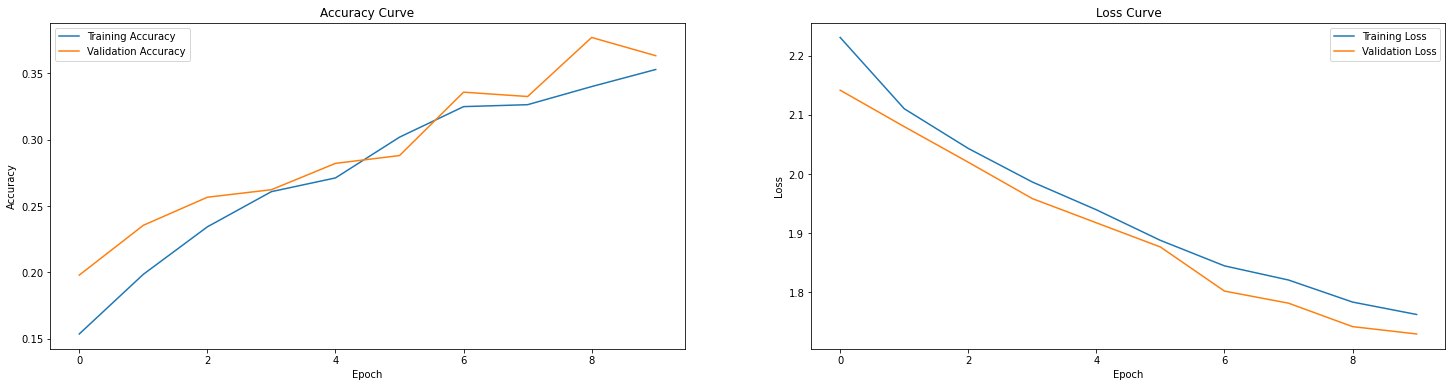

In [ ]:
metrics2 = pd.DataFrame(history_resnet.history)

plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
plt.plot(metrics2.accuracy, label='Training Accuracy')
plt.plot(metrics2.val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics2.loss, label='Training Loss')
plt.plot(metrics2.val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
val_data = valid_data.next()
res = resnet_model.predict(val_data[0])
print(classification_report(np.argmax(val_data[1], axis=1), np.argmax(res, axis=1), target_names=class_name))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.00      0.00      0.00         0
                        Early_blight       0.67      0.50      0.57         4
                         Late_blight       0.00      0.00      0.00         2
                           Leaf_Mold       0.20      1.00      0.33         1
                  Septoria_leaf_spot       0.00      0.00      0.00         3
Spider_mites Two-spotted_spider_mite       0.50      0.25      0.33         4
                         Target_Spot       1.00      1.00      1.00         2
       Tomato_Yellow_Leaf_Curl_Virus       0.33      1.00      0.50         1
                 Tomato_mosaic_virus       0.50      1.00      0.67         1
                             healthy       1.00      0.50      0.67         2

                            accuracy                           0.45        20
                           macro avg       0.42      0.53     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

## VGG19

In [ ]:
vgg19 = tf.keras.applications.VGG19(input_shape=input_shape,
                                        weights='imagenet',
                                        include_top=False)
vgg19.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
#define the layers
inputs = keras.Input(shape=input_shape)

#get the layers
x = vgg19(inputs, training = False)

#stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(11, activation='softmax')(x)

#combine the model
vgg19_model = Model(inputs=inputs, outputs=x)

#summary
vgg19_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                16416     
                                                                 
 dense_5 (Dense)             (None, 11)                363       
                                                           

In [ ]:
# compile model
vgg19_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history_vgg19= vgg19_model.fit( train_data,
                                  epochs=10,
                                  validation_data=valid_data)

Epoch 1/10
533/533 [==============================] - 226s 415ms/step - loss: 1.9490 - accuracy: 0.3650 - val_loss: 1.4614 - val_accuracy: 0.6161
Epoch 2/10
533/533 [==============================] - 218s 409ms/step - loss: 1.3304 - accuracy: 0.5802 - val_loss: 1.1169 - val_accuracy: 0.6682
Epoch 3/10
533/533 [==============================] - 218s 409ms/step - loss: 1.1075 - accuracy: 0.6431 - val_loss: 0.9751 - val_accuracy: 0.6932
Epoch 4/10
533/533 [==============================] - 218s 409ms/step - loss: 0.9953 - accuracy: 0.6682 - val_loss: 0.8662 - val_accuracy: 0.7254
Epoch 5/10
533/533 [==============================] - 218s 409ms/step - loss: 0.9328 - accuracy: 0.6859 - val_loss: 0.7836 - val_accuracy: 0.7551
Epoch 6/10
533/533 [==============================] - 218s 409ms/step - loss: 0.8806 - accuracy: 0.7029 - val_loss: 0.7522 - val_accuracy: 0.7558
Epoch 7/10
533/533 [==============================] - 218s 409ms/step - loss: 0.8440 - accuracy: 0.7145 - val_loss: 0.7286 -

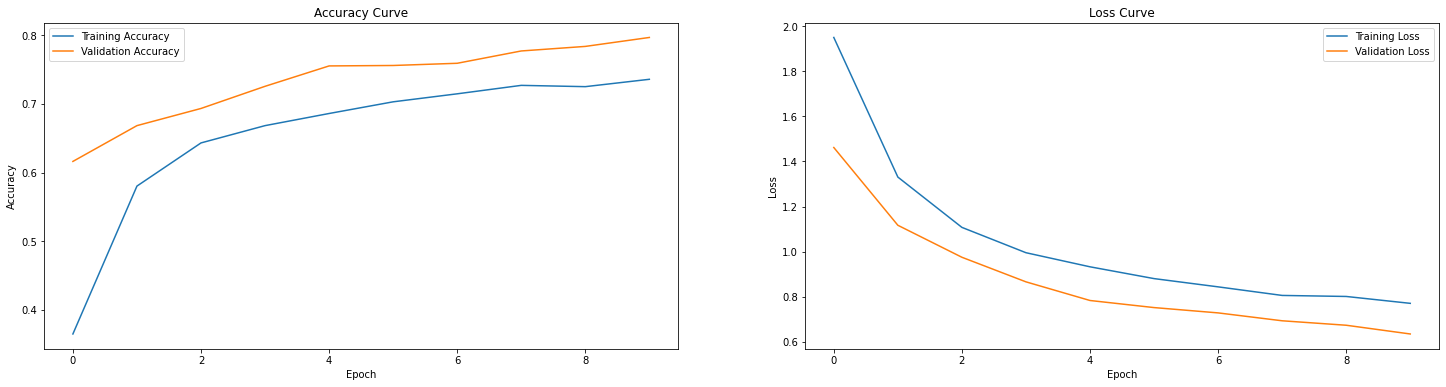

In [ ]:
metrics_vgg19 = pd.DataFrame(history_vgg19.history)

plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
plt.plot(metrics_vgg19.accuracy, label='Training Accuracy')
plt.plot(metrics_vgg19.val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_vgg19.loss, label='Training Loss')
plt.plot(metrics_vgg19.val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = vgg19_model.evaluate(valid_data)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

235/235 [==============================] - 66s 281ms/step - loss: 0.6352 - accuracy: 0.7965
Test accuracy : 0.7965413928031921
Test loss : 0.6352480053901672


In [ ]:
val_data = valid_data.next()
res = vgg19_model.predict(val_data[0])
print(classification_report(np.argmax(val_data[1], axis=1), np.argmax(res, axis=1), target_names=class_name))

                                      precision    recall  f1-score   support

                      Bacterial_spot       1.00      1.00      1.00         5
                        Early_blight       0.00      0.00      0.00         1
                         Late_blight       0.67      1.00      0.80         2
                           Leaf_Mold       1.00      0.33      0.50         3
                  Septoria_leaf_spot       1.00      1.00      1.00         2
Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00         0
                         Target_Spot       0.00      0.00      0.00         0
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.75      0.86         4
                 Tomato_mosaic_virus       1.00      1.00      1.00         1
                             healthy       1.00      1.00      1.00         1
                             unknown       1.00      1.00      1.00         1

                            accuracy                          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## DenseNet

In [ ]:
densenet = tf.keras.applications.DenseNet201(input_shape=input_shape,
                                        weights='imagenet',
                                        include_top=False)
densenet.trainable = False

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
#define the layers
inputs = keras.Input(shape=input_shape)

#get the layers
x = densenet(inputs, training = False)

#stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(11, activation='softmax')(x)

#combine the model
densenet_model = Model(inputs=inputs, outputs=x)

#summary
densenet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                61472     
                                                                 
 dense_3 (Dense)             (None, 11)                363       
                                                           

In [ ]:
# compile model
densenet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history_densenet= densenet_model.fit( train_data,
                                  epochs=10,
                                  validation_data=valid_data)

Epoch 1/10
533/533 [==============================] - 3611s 7s/step - loss: 0.9068 - accuracy: 0.7074 - val_loss: 0.4397 - val_accuracy: 0.8634
Epoch 2/10
533/533 [==============================] - 169s 317ms/step - loss: 0.4162 - accuracy: 0.8669 - val_loss: 0.3119 - val_accuracy: 0.9056
Epoch 3/10
533/533 [==============================] - 170s 319ms/step - loss: 0.3250 - accuracy: 0.8957 - val_loss: 0.2657 - val_accuracy: 0.9182
Epoch 4/10
533/533 [==============================] - 171s 320ms/step - loss: 0.2823 - accuracy: 0.9047 - val_loss: 0.2473 - val_accuracy: 0.9204
Epoch 5/10
533/533 [==============================] - 169s 318ms/step - loss: 0.2577 - accuracy: 0.9105 - val_loss: 0.2131 - val_accuracy: 0.9293
Epoch 6/10
533/533 [==============================] - 170s 319ms/step - loss: 0.2507 - accuracy: 0.9136 - val_loss: 0.2081 - val_accuracy: 0.9304
Epoch 7/10
533/533 [==============================] - 169s 318ms/step - loss: 0.2322 - accuracy: 0.9234 - val_loss: 0.2032 - v

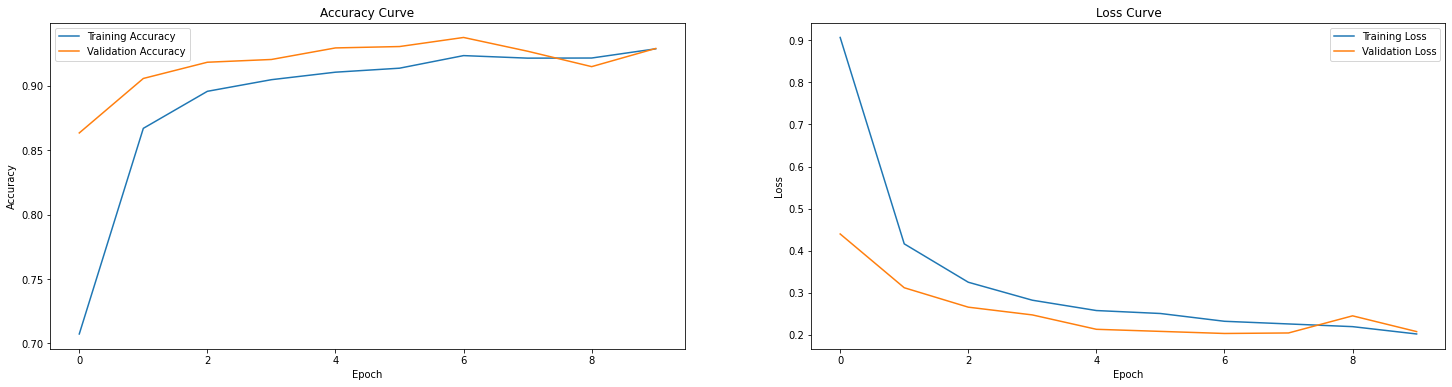

In [ ]:
metrics_densenet = pd.DataFrame(history_densenet.history)

plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
plt.plot(metrics_densenet.accuracy, label='Training Accuracy')
plt.plot(metrics_densenet.val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_densenet.loss, label='Training Loss')
plt.plot(metrics_densenet.val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = densenet_model.evaluate(valid_data)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

235/235 [==============================] - 52s 222ms/step - loss: 0.2077 - accuracy: 0.9289
Test accuracy : 0.9289069175720215
Test loss : 0.20765690505504608


In [ ]:
val_data = valid_data.next()
res = densenet_model.predict(val_data[0])
print(classification_report(np.argmax(val_data[1], axis=1), np.argmax(res, axis=1), target_names=class_name))

                                      precision    recall  f1-score   support

                      Bacterial_spot       1.00      1.00      1.00         1
                        Early_blight       1.00      1.00      1.00         2
                         Late_blight       1.00      1.00      1.00         1
                           Leaf_Mold       1.00      1.00      1.00         4
                  Septoria_leaf_spot       1.00      0.50      0.67         2
Spider_mites Two-spotted_spider_mite       1.00      1.00      1.00         1
                         Target_Spot       0.67      1.00      0.80         2
       Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00         1
                 Tomato_mosaic_virus       1.00      1.00      1.00         2
                             healthy       1.00      1.00      1.00         3
                             unknown       1.00      1.00      1.00         1

                            accuracy                          

In [ ]:
densenet_model.save('unknown_densenet_model.h5')

Model pre-trained densenet akan saya jadikan sebagai model untuk deployment